### Calculate the policy of the agent
* State Variable: x = [w, n, e, s, A], action variable a = [c, b, k], both of them are numpy array 

In [8]:
%pylab inline
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
from scipy.interpolate import interp2d
from multiprocessing import Pool
from functools import partial 
from pyswarm import pso
import warnings
from scipy import optimize

warnings.filterwarnings("ignore")
np.printoptions(precision=2)
# time line
T_min = 0
T_max = 70
T_R = 45
beta = 1/(1+0.02)
# All the money amount are denoted in thousand dollars
earningShock = [0.8,1.2]
# Define transition matrix of economical states
# GOOD -> GOOD 0.8, BAD -> BAD 0.6 
Ps = np.array([[0.6, 0.4],[0.2, 0.8]])
# current risk free interest rate 
r_f = np.array([0.01 ,0.03])
# stock return depends on current and future econ states
r_m = np.array([[-0.2, 0.15],[-0.15, 0.2]])
# expected return on stock market 
r_bar = 0.0667
# probability of survival
Pa = np.load("prob.npy")
# probability of employment transition 
Pe = np.array([[[[0.3, 0.7], [0.1, 0.9]], [[0.25, 0.75], [0.05, 0.95]]],
               [[[0.25, 0.75], [0.05, 0.95]], [[0.2, 0.8], [0.01, 0.99]]]])
# deterministic income
detEarning = np.load("detEarning.npy")
# tax rate 
tau_L = 0.2
tau_R = 0.1
# minimum consumption
c_bar = 3

Populating the interactive namespace from numpy and matplotlib


In [9]:
#Define the utility function
def u(c):
    gamma = 2
    return (np.float_power(max(c-c_bar,0),1-gamma) - 1)/(1 - gamma)

#Define the bequeath function, which is a function of wealth 
def uB(w):
    B = 2
    return B*u(w)

#Define the earning function 
def y(t, x):
    w, n, s, e, A = x
    if A == 0:
        return 0
    else:
        if t <= T_R:
            return detEarning[t] * earningShock[int(s)] * e + (1-e)*5
        else:
            return detEarning[t]

# Define the reward funtion
def R(x, a):
    c, b, k = a
    w, n, s, e, A = x
    if A == 0:
        return uB(w+n)
    else:
        return u(c)

# Define the transtiion of state (test)
def transition(x, a, t):
    '''
        Input: x current state: (w, n, e, s, A) 
               a action taken: (c, b, k)
        Output: the next possible states with corresponding probabilities
    '''
    c, b, k = a
    w, n, s, e, A = x
    
    x_next = []
    prob_next = []
    # Agent is dead 
    if A == 0:
        for s_next in [0, 1]:
            x_next.append([0, 0, s_next, 0, 0])
        return np.array(x_next), Ps[int(s)]
    else:
        # after retirement calculate the annuity payment
        N = np.sum(Pa[t:])
        discounting = ((1+r_bar)**N - 1)/(r_bar*(1+r_bar)**N)
        # A = 1, agent is still alive and for the next period
        Pat = [1-Pa[t], Pa[t]]
        r_bond = r_f[int(s)]
        for s_next in [0, 1]:
            r_stock = r_m[int(s), s_next]
            w_next =  b*(1+r_bond) + k*(1+r_stock)
            if t < T_R:
                # before retirement agents put 5% of income to 401k
                n_next = (n+0.05*y(t,x))(1+r_stock)
            else:
                n_next = (n-n/discounting)*(1+r_stock)
            for e_next in [0,1]:
                for A_next in [0,1]:
                    # Age reaches 65 or agent is dead directly results in unemployment
                    if t > T_R or A_next == 0:
                        if A_next == 0:
                            n_next = n*(1+r_stock)
                        x_next.append([w_next, n_next, s_next, 0, A_next])
                    else:
                        x_next.append([w_next, n_next, s_next, e_next, A_next])
                    prob_next.append(Ps[int(s)][s_next] * Pat[A_next] * Pe[int(s),s_next,int(e),e_next])
        return np.array(x_next), np.array(prob_next) 
    
    
# Value function is a function of state and time t
def V(x, t, Vmodel):
    # Define the objective function as a function of action
    w, n, s, e, A = x
    if A == 0:
        return np.array([R(x,[0,0,0]),[0,0,0]])
    else: 
        N = np.sum(Pa[t:])
        discounting = ((1+r_bar)**N - 1)/(r_bar*(1+r_bar)**N)
        def obj(bkTheta):
            bk,theta = bkTheta
            b = bk * theta
            k = bk * (1-theta)
            if t < T_R:
                c = (1-tau_L)*(y(t, x) * (1-0.05)) + w - bk
            else:
                c = (1-tau_R)*y(t, x) + w + n/discounting - bk
            if c <= c_bar:
                return 9999999999
            a = (c,b,k)
            x_next, prob_next = transition(x, a, t)
            return -(R(x, a) + beta * np.dot(Vmodel[int(s)][int(e)][int(A)](x_next[:,0], x_next[:,1]), prob_next))

        if t < T_R:
            ub = [(1-tau_L)*(y(t, x) * (1-0.05)) + w, 1]
        else:
            ub = [(1-tau_R)*y(t, x) + w + n/discounting, 1]
        lb = [0, 0]
        
        xopt, fopt = pso(obj, lb, ub)
        max_val = -fopt
        bk_m, theta_m = xopt
        b_m = bk_m * theta_m
        k_m = bk_m * (1-theta_m)
        
        if t < T_R:
            c_m = (1-tau_L)*(y(t, x) * (1-0.05)) + w - bk_m
        else:
            c_m = (1-tau_R)*y(t, x) + w + n/discounting - bk_m
        return np.array([max_val, [c_m, b_m, k_m]])

In [6]:
# wealth discretization 
w_grid_size = 100
w_lower = 5
w_upper = 20000
# 401k amount discretization 
n_grid_size = 10
n_lower = 5
n_upper = 500

def powspace(start, stop, power, num):
    start = np.power(start, 1/float(power))
    stop = np.power(stop, 1/float(power))
    return np.power( np.linspace(start, stop, num=num), power)

# initialize the state discretization 
x_T = np.array([[w,n,e,s,0]   for w in powspace(w_lower, w_upper, 3, w_grid_size)
                            for n in np.linspace(n_lower, n_upper, n_grid_size)
                            for s in [0,1]
                            for e in [0,1]
                            for A in [0,1]]).reshape((w_grid_size, n_grid_size, 2,2,2,5))

xgrid = np.array([[w,n,e,s,A] for w in powspace(w_lower, w_upper, 3, w_grid_size)
                            for n in powspace(n_lower, n_upper, 3, n_grid_size)
                            for s in [0,1]
                            for e in [0,1]
                            for A in [0,1]]).reshape((w_grid_size, n_grid_size, 2,2,2,5))

Vgrid = np.zeros((w_grid_size, n_grid_size, 2, 2, 2, T_max+1))
cgrid = np.zeros((w_grid_size, n_grid_size, 2, 2, 2, T_max+1))
bgrid = np.zeros((w_grid_size, n_grid_size, 2, 2, 2, T_max+1))
kgrid = np.zeros((w_grid_size, n_grid_size, 2, 2, 2, T_max+1))

# apply function to state space, need to reshape the matrix and shape it back to the size
def applyFunToCalculateValue(fun, x = xgrid):
    return np.array(list(map(fun, x.reshape((w_grid_size * n_grid_size * 2 * 2 * 2, 5))))).reshape((w_grid_size, n_grid_size, 2,2,2))

Vgrid[:,:,:,:,:, T_max] = applyFunToCalculateValue(partial(R, a = [0,0,0]), x = x_T)

### Backward Induction Part

In [7]:
%%time 
ws = xgrid[:,:,1,1,1,0].flatten()
ns = xgrid[:,:,1,1,1,1].flatten()

xs = xgrid.reshape((w_grid_size * n_grid_size * 2 * 2 * 2, 5))

pool = Pool()

for t in range(T_max-1, 0, -1):
    print(t)
    cs = [[[np.vectorize(interp2d(ws, ns, Vgrid[:,:,s,e,A,t+1].flatten(),kind= 'cubic'))
            for A in [0,1]] for e in [0,1]] for s in [0,1]]
    f = partial(V, t = t, Vmodel = cs)
    #results = np.array(pool.map(f, xs))
    results = []
    for i in range(w_grid_size * n_grid_size * 2 * 2 * 2):
        if i % 100 == 0:
            print(i)
        results.append(f(xs[i]))
    results = np.array(results)
    
    Vgrid[:,:,:,:,:,t] = results[:,0].reshape((w_grid_size,n_grid_size, 2,2,2))
    #########################################################[test function part] 
    fig = plt.figure(figsize = [12, 8])
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X = ws.reshape((w_grid_size, n_grid_size)), Y = ns.reshape((w_grid_size, n_grid_size)), Z=  Vgrid[:,:,1,1,1,t])
    plt.show()
    #########################################################
    cgrid[:,:,:,:,:,t] = np.array([r[0] for r in results[:,1]]).reshape((w_grid_size, n_grid_size,2,2,2))
    bgrid[:,:,:,:,:,t] = np.array([r[1] for r in results[:,1]]).reshape((w_grid_size, n_grid_size,2,2,2))
    kgrid[:,:,:,:,:,t] = np.array([r[2] for r in results[:,1]]).reshape((w_grid_size, n_grid_size,2,2,2))
pool.close()

69
0
100


Process ForkPoolWorker-70:
Process ForkPoolWorker-76:
Process ForkPoolWorker-86:
Process ForkPoolWorker-95:
Process ForkPoolWorker-85:
Process ForkPoolWorker-72:
Process ForkPoolWorker-77:
Process ForkPoolWorker-73:
Process ForkPoolWorker-71:
Process ForkPoolWorker-74:
Process ForkPoolWorker-89:
Process ForkPoolWorker-79:
Process ForkPoolWorker-91:
Process ForkPoolWorker-83:
Process ForkPoolWorker-94:
Process ForkPoolWorker-90:
Process ForkPoolWorker-84:
Process ForkPoolWorker-96:
Process ForkPoolWorker-88:
Process ForkPoolWorker-87:
Process ForkPoolWorker-75:
Process ForkPoolWorker-80:
Process ForkPoolWorker-82:
Process ForkPoolWorker-78:
Process ForkPoolWorker-69:
Process ForkPoolWorker-65:
Process ForkPoolWorker-81:
Process ForkPoolWorker-93:
Process ForkPoolWorker-66:
Process ForkPoolWorker-92:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most

KeyboardInterrupt: 

Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkPoolWorker-68:
Process ForkPoolWorker-67:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/hfsluser/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/hfsluser/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/hf

  File "/home/hfsluser/anaconda3/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/home/hfsluser/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/hfsluser/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/hfsluser/anaconda3/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/home/hfsluser/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/hfsluser/anaconda3/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/home/hfsluser/anaconda3/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/home/hfsluser/anaconda3/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/home/hfsluser/anaconda3/lib

  File "/home/hfsluser/anaconda3/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/home/hfsluser/anaconda3/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/home/hfsluser/anaconda3/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/home/hfsluser/anaconda3/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/home/hfsluser/anaconda3/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/home/hfsluser/anaconda3/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/home/hfsluser/anaconda3/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/home/hfsluser/anaconda3/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__


69


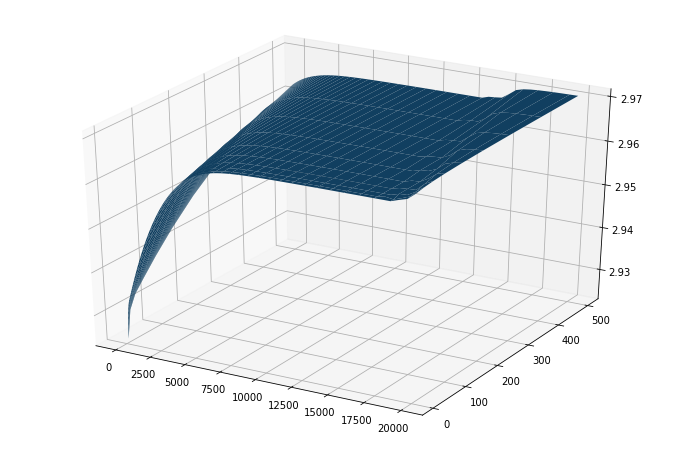

68


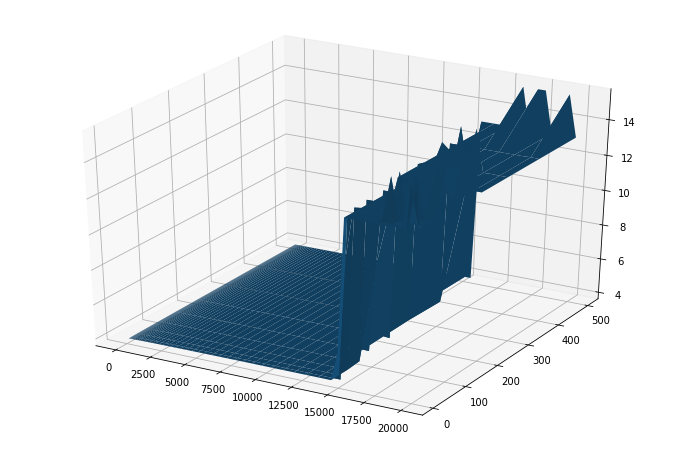

67


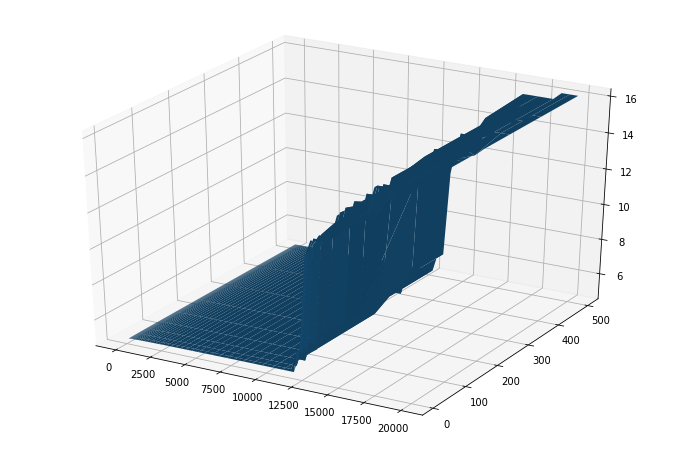

66


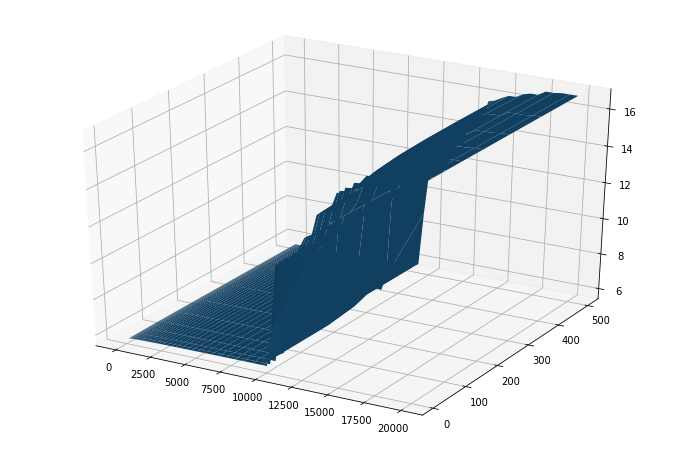

65


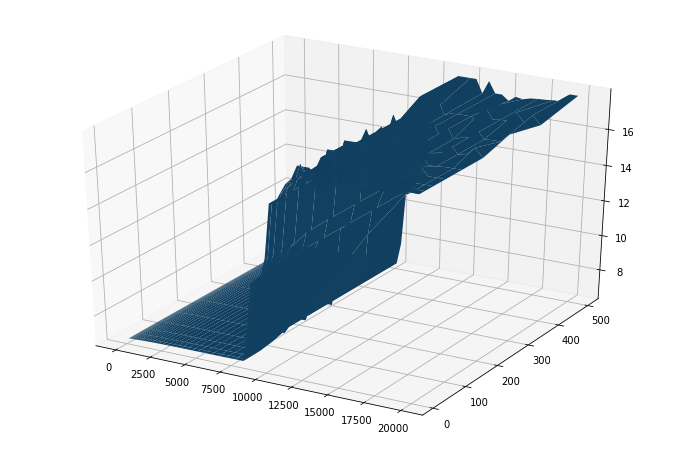

64


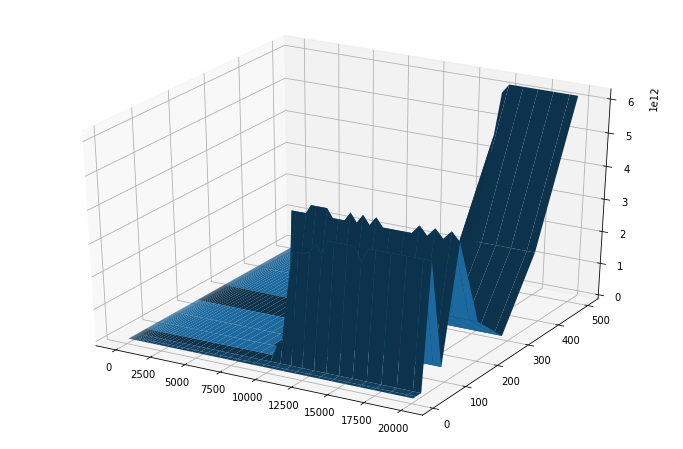

63


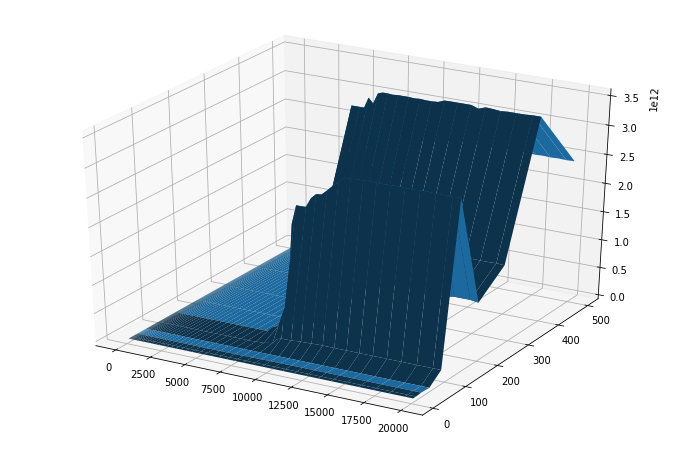

62


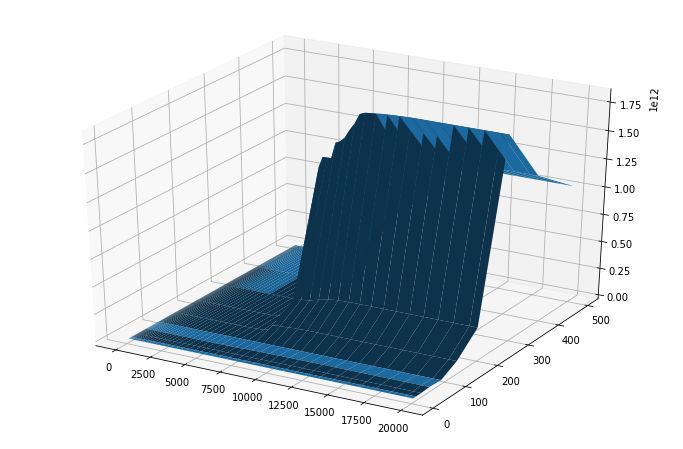

61


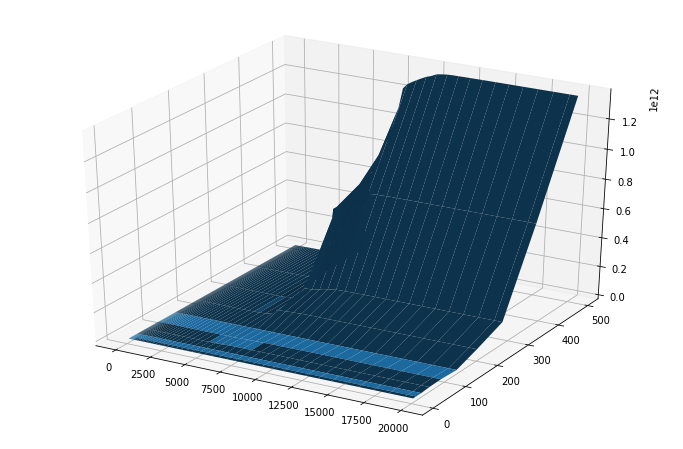

CPU times: user 2min 15s, sys: 24.1 s, total: 2min 39s
Wall time: 2h 7min 32s


In [4]:
%%time 
ws = xgrid[:,:,1,1,1,0].flatten()
ns = xgrid[:,:,1,1,1,1].flatten()

xs = xgrid.reshape((w_grid_size * n_grid_size * 2 * 2 * 2, 5))

pool = Pool()

for t in range(T_max-1, 0, -1):
    print(t)
    cs = [[[np.vectorize(interp2d(ws, ns, Vgrid[:,:,s,e,A,t+1].flatten(),kind= 'cubic'))
            for A in [0,1]] for e in [0,1]] for s in [0,1]]
    f = partial(V, t = t, Vmodel = cs)
    results = np.array(pool.map(f, xs))
    
    Vgrid[:,:,:,:,:,t] = results[:,0].reshape((w_grid_size,n_grid_size, 2,2,2))
    #########################################################[test function part] 
    fig = plt.figure(figsize = [12, 8])
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X = ws.reshape((w_grid_size, n_grid_size)), Y = ns.reshape((w_grid_size, n_grid_size)), Z=  Vgrid[:,:,1,1,1,t])
    plt.show()
    #########################################################
    cgrid[:,:,:,:,:,t] = np.array([r[0] for r in results[:,1]]).reshape((w_grid_size, n_grid_size,2,2,2))
    bgrid[:,:,:,:,:,t] = np.array([r[1] for r in results[:,1]]).reshape((w_grid_size, n_grid_size,2,2,2))
    kgrid[:,:,:,:,:,t] = np.array([r[2] for r in results[:,1]]).reshape((w_grid_size, n_grid_size,2,2,2))
pool.close()

In [5]:
def summaryPlotChoiceVStime(w_level, n_level, s, e, A, V = Vgrid, C = cgrid, B = bgrid, K = kgrid):
    plt.figure(figsize = [12,8])
    plt.plot(list(range(20,91)), cgrid[w_level, n_level, s,e,A,:], label= "Consumption")
    plt.plot(list(range(20,91)), bgrid[w_level, n_level, s,e,A,:], label= "Bond Holding")
    plt.plot(list(range(20,91)), kgrid[w_level, n_level, s,e,A,:], label= "Stock Holding")
    plt.legend()
    plt.show()
summaryPlotChoiceVStime(50, 0, 1, 1)

TypeError: summaryPlotChoiceVStime() missing 1 required positional argument: 'A'

In [ ]:
def summaryPlotWealthVSChoice(t, s, e, A, V = Vgrid, C = cgrid, B = bgrid, K = kgrid):
    plt.figure(figsize = [12,8])
    plt.plot(ws, cgrid[:,s,e,A,t], label="Consumption")
    plt.plot(ws, bgrid[:,s,e,A,t], label="Bond Holding")
    plt.plot(ws, kgrid[:,s,e,A,t], label="Stock Holding")
    plt.legend()
    plt.show()
summaryPlotWealthVSChoice(60, 0, 1, 1)

### Simulation Part

In [ ]:
import quantecon as qe
mc = qe.MarkovChain(Ps)

def action(t, x):
    w,s,e,A = x
    if A == 1:
        c = interp1d(ws, cgrid[:,s,e,A,t], kind = "linear", fill_value = "extrapolate")(w)
        b = interp1d(ws, bgrid[:,s,e,A,t], kind = "linear", fill_value = "extrapolate")(w)
        k = interp1d(ws, kgrid[:,s,e,A,t], kind = "linear", fill_value = "extrapolate")(w)
    else:
        c = 0
        b = 0
        k = 0
    return (c,b,k)

# Define the transtiion of state 
def transition(x, a, t, s_next):
    '''
        Input: x current state: (w, n, s, A) 
               a action taken: (c, b, k)
        Output: the next possible states with corresponding probabilities
    '''
    c, b, k = a
    w, s, e, A = x
    
    x_next = []
    prob_next = []
    if A == 0:
        return [0, s_next, 0, 0]
    else:
        # A = 1, agent is still alive and for the next period
        Pat = [1-Pa[t], Pa[t]]
        r_bond = r_f[int(s)]
        r_stock = r_m[int(s), s_next]
        w_next =  b*(1+r_bond) + k*(1+r_stock)
        for e_next in [0,1]:
            for A_next in [0,1]:
                x_next.append([w_next, s_next, e_next, A_next])
                prob_next.append(Pat[A_next] * Pe[int(s),s_next,int(e),e_next])
    return x_next[np.random.choice(4, 1, p = prob_next)[0]]

In [ ]:
def simulation(num):
    for sim in range(num):
        if sim%100 == 0:
            print(sim)
        # simulate an agent age 15 starting with wealth of 10
        w = 20
        wealth = []
        Consumption = []
        Bond = []
        Stock = []
        Salary = []
        econState = mc.simulate(ts_length=T_max - T_min)
        alive = True
        for t in range(len(econState)-1):
            if rd.random() > prob[t]:
                alive = False
            wealth.append(w)
            s = econState[t]
            s_next = econState[t+1]
            a = action(t, w, s, alive)
            if alive:
                Salary.append(y(t+T_min, s))
            else:
                Salary.append(0)
            Consumption.append(a[0])
            Bond.append(a[1])
            Stock.append(a[2])
            w = fixTransition(w,s,s_next, a, alive)
        # dictionary of lists  
        dictionary = {'wealth': wealth,
                      'Consumption': Consumption, 
                      'Bond': Bond, 
                      'Stock': Stock,
                      'Salary': Salary}
        if sim == 0:
            df = pd.DataFrame(dictionary) 
        else:
            df = df + pd.DataFrame(dictionary)           
    return df/num 

In [ ]:
# simulate an agent age 0 starting with wealth of 70
econState = mc.simulate(ts_length=T_max - T_min)
def simulateAgent(sim):
    wealth = []
    Consumption = []
    Bond = []
    Stock = []
    Salary = []
    employ = []
    live = []
    x = [20, 0, 0, 1]
    for t in range(len(econState)-1):
        s = econState[t]
        s_next = econState[t+1]
        a = action(t, x)
        c, b, k = a
        w,_,e,A = x
        
        wealth.append(w)
        Consumption.append(c)
        Bond.append(b)
        Stock.append(k)
        Salary.append(y(t, x))
        employ.append(e)
        live.append(A)
        x = transition(x, a, t, s_next)
    # dictionary of lists  
    dictionary = {'wealth': wealth,
                  'Consumption': Consumption, 
                  'Bond': Bond, 
                  'Stock': Stock,
                  'Salary': Salary,
                  'employ': employ,
                  'live': live}
    return pd.DataFrame(dictionary)

In [ ]:
pool = Pool()
sim = 10000
agents = pool.map(simulateAgent, list(range(sim)))
pool.close()

In [ ]:
df = pd.DataFrame()
for agent in agents:
    if df.size == 0:
        df = agent
    else:
        df = df + agent
df = df/sim

In [ ]:
df = df/10000

In [ ]:
df.plot()

In [ ]:
df[["wealth","Consumption","Bond","Stock"]].plot()